# setup

In [4]:
%cd ..
%ls

c:\Users\Ema\Documents\MEGA\POLIMI\MAGISTRALE\COMP STAT\neuraluq-CSproject
 Volume in drive C has no label.
 Volume Serial Number is 42DD-6E47

 Directory of c:\Users\Ema\Documents\MEGA\POLIMI\MAGISTRALE\COMP STAT\neuraluq-CSproject

22/03/2023  17:18    <DIR>          .
22/03/2023  17:18    <DIR>          ..
22/03/2023  17:18    <DIR>          dataset
22/03/2023  17:18    <DIR>          examples
22/03/2023  17:18    <DIR>          neuraluq
22/03/2023  17:18             3.497 README.md
22/03/2023  17:26    <DIR>          scripts
22/03/2023  17:18               649 setup.py
               2 File(s)          4.146 bytes
               6 Dir(s)  19.181.719.552 bytes free


In [5]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

ModuleNotFoundError: No module named 'tensorflow'

# New Section

## utilities

### def load_data

In [2]:
def load_data():
    data = sio.loadmat("../lotka_volterra_dataset_1.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_u_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.05
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

### def ode_fn

In [3]:
def ode_fn(t, u, a, b, c, d, e, f, g):
    u1, u2, u3 = tf.split(u, 3, axis=-1)
    u1_t = tf.gradients(u1, t)[0]
    u2_t = tf.gradients(u2, t)[0]
    u3_t = tf.gradients(u3, t)[0]
# Lotka-Volterra
    f1 = u1_t - a*u1 + b*u1*u2
    f2 = u2_t + c*u2 - d*u1*u2 + e*u2*u3
    f3 = u3_t + f*u3 - g*u2*u3
    return tf.concat([f1, f2, f3], axis=-1)

### def plots

In [4]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]  # training data
    t2_train, u2_train = t_u_train[:80], u_train[:80, 1:2]  # training data

  # plot parameters' histograms
    neuq.utils.hist(k1_pred, name="value of $k1$")
    neuq.utils.hist(k2_pred, name="value of $k2$")
    neuq.utils.hist(k3_pred, name="value of $k3$")
    neuq.utils.hist(k4_pred, name="value of $k4$")
    neuq.utils.hist(k5_pred, name="value of $k5$")
    neuq.utils.hist(k6_pred, name="value of $k6$")
    neuq.utils.hist(k7_pred, name="value of $k7$")
  
  # plot x1, x2, x3
    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
        xlim=[0, 10],
        ylim=[0, 2],
    )
    neuq.utils.plot1d(
        t2_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
        xlim=[0, 10],
        ylim=[0, 2],
    )
    neuq.utils.plot1d(
        t_u_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
        xlim=[0, 10],
        ylim=[0, 2],
    )

### def solve_ode

In [12]:
# instead of using the built in plot function, we solve the LV system again 
# taking as parameters the output of the feed forward NN

def odesystem(t, y, a, b, c, d, e, f, g):
    x, y, z = y
    dxdt = a*x - b*x*y
    dydt = -c*y + d*x*y - e*y*z
    dzdt = -f*z + g*y*z
    return [dxdt, dydt, dzdt]

def solveODE(a, b, c, d, e, f, g):
  y0 = [1, 1, 1]
  t_span = [0, 10]
  sol = solve_ivp(lambda t, y: odesystem(t, y, a, b, c, d, e, f, g), t_span, y0, t_eval=np.linspace(0, 10, 1000))
  return sol

def plot_and_save(sol, sol_ex, title):
  fig, axs = plt.subplots(3, sharex=True, figsize=(12,12))
  fig.suptitle(title)

  axs[0].plot(sol_ex.t, sol_ex.y[0], 'b', label='sol_ex')
  axs[0].plot(sol.t, sol.y[0], 'r', label='sol_neuraluq')
  axs[0].legend(loc='best')
  axs[0].set_ylabel('x')

  axs[1].plot(sol_ex.t, sol_ex.y[1], 'b', label='sol_ex')
  axs[1].plot(sol.t, sol.y[1], 'r', label='sol_neuraluq')
  axs[1].legend(loc='best')
  axs[1].set_ylabel('y')

  axs[2].plot(sol_ex.t, sol_ex.y[2], 'b', label='sol_ex')
  axs[2].plot(sol.t, sol.y[2], 'r', label='sol_neuraluq')
  axs[2].legend(loc='best')
  axs[2].set_ylabel('z')
  axs[2].set_xlabel('t')

  plt.savefig(title + '.png')
  plt.show()
  

def plot_and_saveUQ(sol, sol_up, sol_down, sol_ex, title):
  fig, axs = plt.subplots(3, sharex=True, figsize=(16,16))
  fig.suptitle(title)

  for i in range(3):
    axs[i].plot(sol_ex.t, sol_ex.y[i], 'b', label='sol_ex')
    axs[i].plot(sol.t, sol.y[i], 'r--', label='mean')
    axs[i].plot(sol_down.t, sol.y[i], 'g', lw='0.5')
    axs[i].plot(sol_up.t, sol.y[i], 'g', lw='0.5')
    axs[i].fill_between(sol.t, sol_up.y[i], sol_down.y[i])
    axs[i].legend(loc='best')
    axs[i].set_ylabel('x')

  plt.savefig(title + '.png')
  plt.show()
  


### def samplable

In [6]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):  
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:80], u_train[:80, 1:2]
        
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )

    # I build the same process for all the parameters...
    process_k1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k3 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k4 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k5 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k6 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_k7 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    
    # build likelihood
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        pde=ode_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(                                         
        num_samples=1000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))

    processes = [process_u, process_k1, process_k2, process_k3, process_k4, process_k5, process_k6, process_k7]
    return processes, samples, model

## run model [1:5:5:3]

In [10]:
################## Load data and specify some hyperparameters ####################
data = load_data()
t_u_train, u_train, t_f_train, f_train, noise = data[:5]
t_test, u_test = data[5:]
layers = [1, 10, 10, 3]

processes, samples, model = Samplable(
    t_u_train, u_train, t_f_train, f_train, noise, layers
)

u_pred, k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred = model.predict(t_test, samples, processes, pde_fn=None)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.706 

Execution time for 'Samplable' function is: 328.244 s, 5.471 mins


## postprocessing

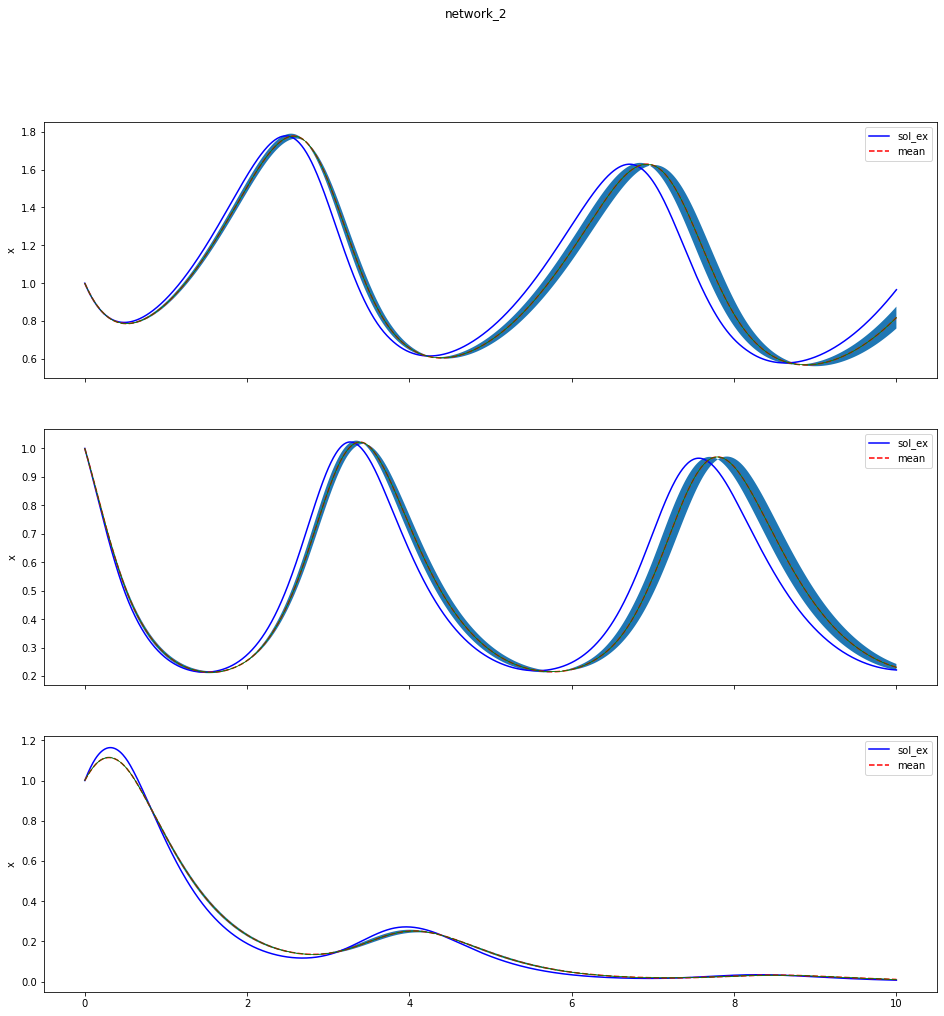

In [13]:
sol_ex = solveODE(1, 2, 2, 2, 1, 2, 3)

sol = solveODE(k1_pred.mean(), k2_pred.mean(), k3_pred.mean(), 
                k4_pred.mean(), k5_pred.mean(), k6_pred.mean(), k7_pred.mean())

sol_up = solveODE(k1_pred.mean() + 2*k1_pred.var(),
                  k2_pred.mean() + 2*k2_pred.var(),
                  k3_pred.mean() + 2*k3_pred.var(), 
                  k4_pred.mean() + 2*k4_pred.var(), 
                  k5_pred.mean() + 2*k5_pred.var(), 
                  k6_pred.mean() + 2*k6_pred.var(), 
                  k7_pred.mean() + 2*k7_pred.var() )

sol_down = solveODE(k1_pred.mean() - 2*k1_pred.var(),
                  k2_pred.mean() - 2*k2_pred.var(),
                  k3_pred.mean() - 2*k3_pred.var(), 
                  k4_pred.mean() - 2*k4_pred.var(), 
                  k5_pred.mean() - 2*k5_pred.var(), 
                  k6_pred.mean() - 2*k6_pred.var(), 
                  k7_pred.mean() - 2*k7_pred.var() )

# plot_and_save(sol, sol_ex, 'network [1, 5, 5, 3]')
plot_and_saveUQ(sol, sol_up, sol_down, sol_ex, 'network_2')


## run model [1:10:10:3]

In [ ]:
################## Load data and specify some hyperparameters ####################
data = load_data()
t_u_train, u_train, t_f_train, f_train, noise = data[:5]
t_test, u_test = data[5:]
layers = [1, 10, 10, 3]

processes, samples, model = Samplable(
    t_u_train, u_train, t_f_train, f_train, noise, layers
)

u_pred, k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred = model.predict(t_test, samples, processes, pde_fn=None)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.706 

Execution time for 'Samplable' function is: 267.068 s, 4.451 mins


## postprocessing

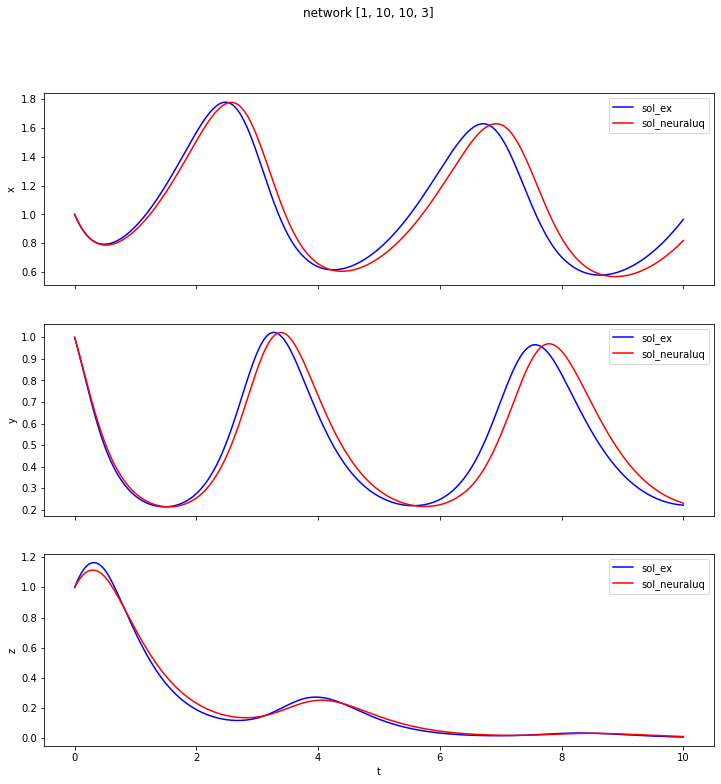

<Figure size 432x288 with 0 Axes>

In [ ]:
sol_ex = solveODE(1, 2, 2, 2, 1, 2, 3)

sol = solveODE(k1_pred.mean(), k2_pred.mean(), k3_pred.mean(), 
                k4_pred.mean(), k5_pred.mean(), k6_pred.mean(), k7_pred.mean())

plot_and_save(sol, sol_ex, 'network [1, 10, 10, 3]')

## run models with increasing layers

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.607 

Execution time for 'Samplable' function is: 598.386 s, 9.973 mins


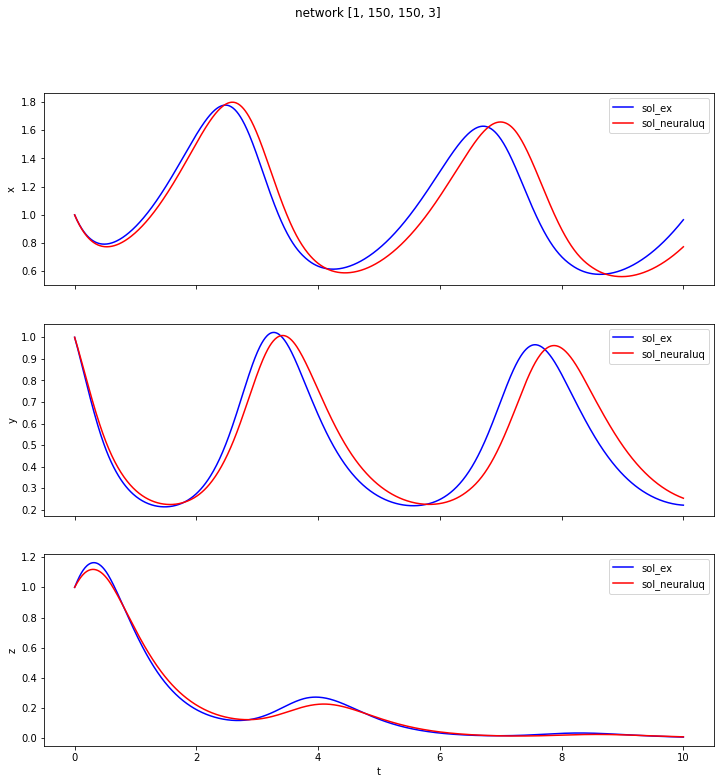

[[0.0428164  0.06255007 0.1748718  0.17338014 0.082645   0.19365442
  0.42845798]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...



InvalidArgumentError: ignored

In [ ]:
################## Load data and specify some hyperparameters ####################

sol_ex = solveODE(1, 2, 2, 2, 1, 2, 3)
data = load_data()
t_u_train, u_train, t_f_train, f_train, noise = data[:5]
t_test, u_test = data[5:]

l = [150, 200, 300, 400] # increasing number of layers
errors = np.zeros(shape=(4, 7))
for count, i in enumerate(l):
  layers = [1, i, i, 3]

  processes, samples, model = Samplable(
      t_u_train, u_train, t_f_train, f_train, noise, layers
  )
  u_pred, k1_pred, k2_pred, k3_pred, k4_pred, k5_pred, k6_pred, k7_pred = model.predict(t_test, samples, processes, pde_fn=None)

  errors[count, 0] = np.linalg.norm(1-k1_pred.mean())
  errors[count, 1] = np.linalg.norm(2-k2_pred.mean())
  errors[count, 2] = np.linalg.norm(2-k3_pred.mean())
  errors[count, 3] = np.linalg.norm(2-k4_pred.mean())
  errors[count, 4] = np.linalg.norm(1-k5_pred.mean())
  errors[count, 5] = np.linalg.norm(2-k6_pred.mean())
  errors[count, 6] = np.linalg.norm(3-k7_pred.mean())

  sol = solveODE(k1_pred.mean(), k2_pred.mean(), k3_pred.mean(), 
                k4_pred.mean(), k5_pred.mean(), k6_pred.mean(), k7_pred.mean())
  
  png_title = 'network [1, '+ str(i) +', ' + str(i) + ', 3]'
  plot_and_save(sol, sol_ex, png_title)
  print(errors)

print(errors)

fig, ax = plt.subplots()
for i in range(errors.shape[1]):
    ax.plot(data[:,i], label=f'param: {i+1}')
ax.legend()
plt.savefig('errors.png')
plt.show()

## downloading results

In [ ]:
%ls

 build/                       'network [1, 15, 15, 3].png'   neuraluq/
 dataset/                     'network [1, 20, 20, 3].png'   NeuralUQ.egg-info/
 dist/                        'network [1, 50, 50, 3].png'   README.md
 examples/                    'network [1, 5, 5, 3].png'     setup.py
'network [1, 10, 10, 3].png'  'network [1, 80, 80, 3].png'


In [ ]:
from google.colab import files
files.download('network [1, 20, 20, 3].png')
files.download('network [1, 50, 50, 3].png')
files.download('network [1, 80, 80, 3].png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!rm 'network 1.png' 'network [1, 10, 10, 3].png' 'network [1, 5, 5, 3].png' 'Solutions with Network [1, 10, 10, 3].png' 'Solutions with Network [1, 5, 5, 3].png'

rm: cannot remove 'network [1, 10, 10, 3].png': No such file or directory
rm: cannot remove 'network [1, 5, 5, 3].png': No such file or directory
rm: cannot remove 'Solutions with Network [1, 10, 10, 3].png': No such file or directory
rm: cannot remove 'Solutions with Network [1, 5, 5, 3].png': No such file or directory


## plot all the graphs and the error decay

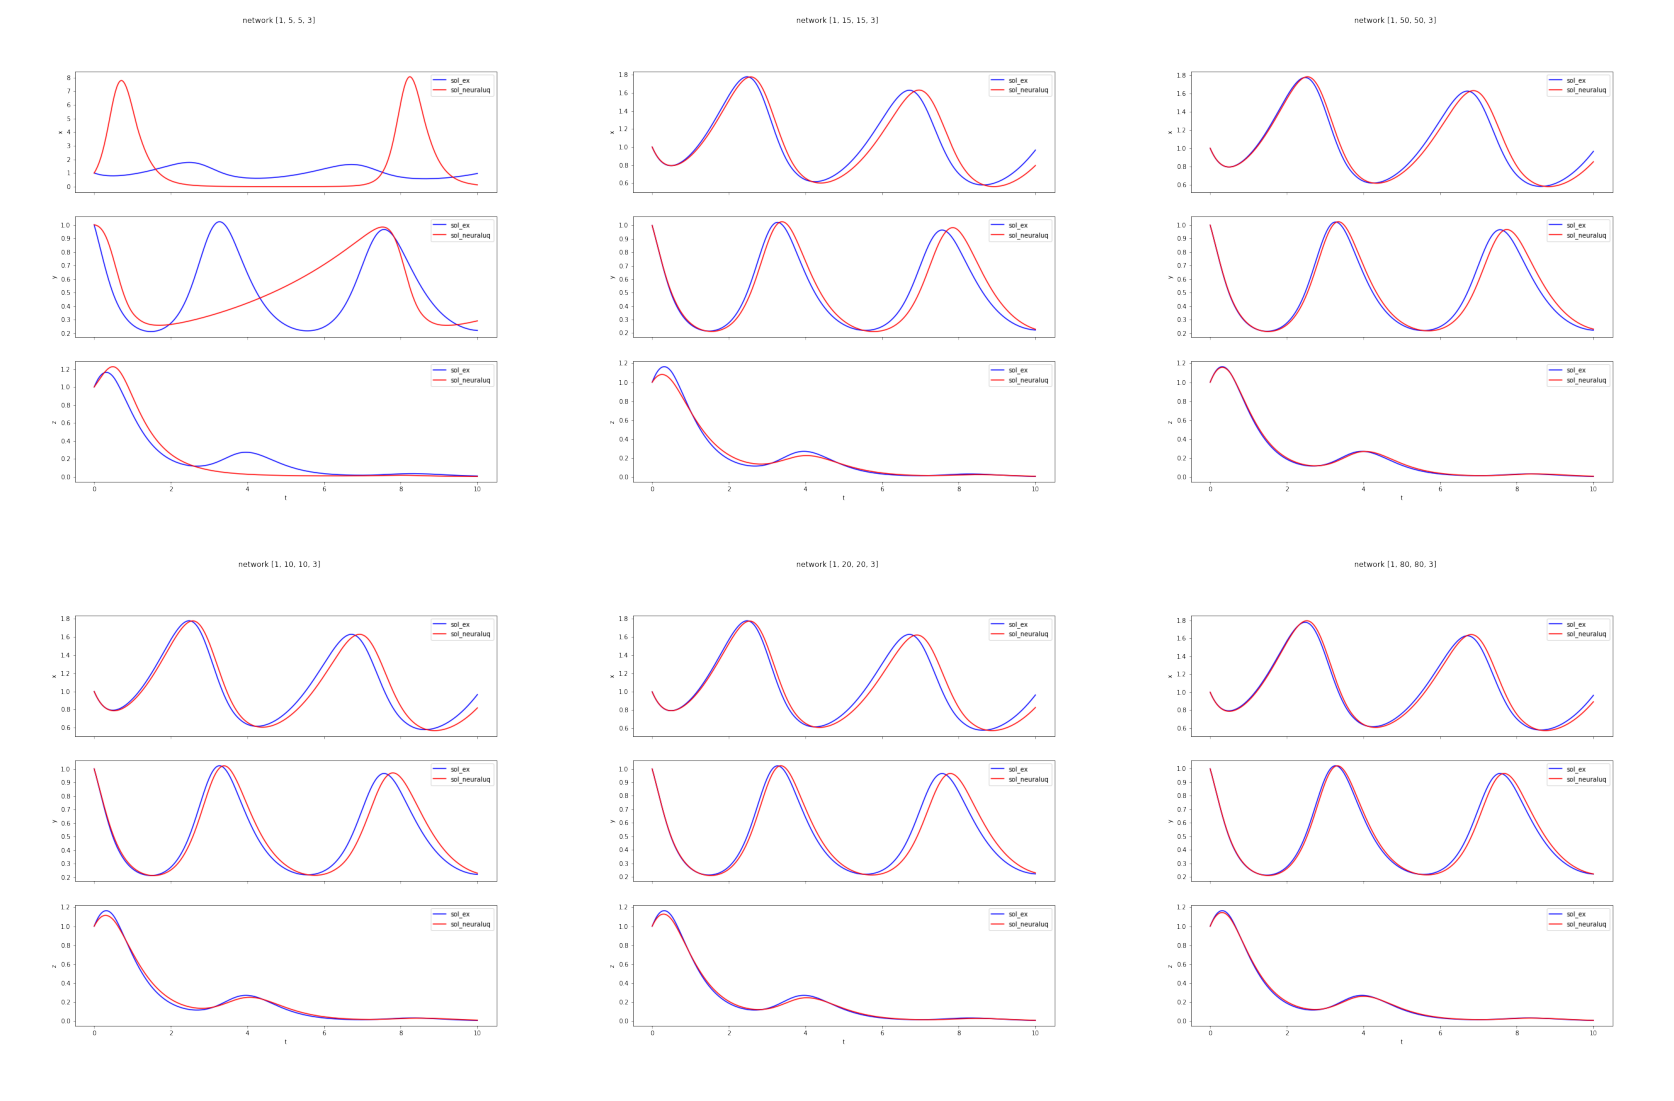

In [ ]:
import os

# Set up the plot grid
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
# Get the list of image files in the current directory
image_files = [file for file in os.listdir() if file.endswith('.png')][:6]

# Loop through the images and display them
for i, file in enumerate(image_files):
    # Load the image
    image = plt.imread(file)

    # Calculate the row and column index
    col = i // 2
    row = i % 2

    # Display the image in the correct subplot
    ax[row, col].imshow(image)
    ax[row, col].axis('off')

fig.subplots_adjust(wspace=0, hspace=0)

plt.savefig('network_layers_comparison.png')

# Show the plot
plt.show()


In [ ]:
files.download('network_layers_comparison.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## plot errors

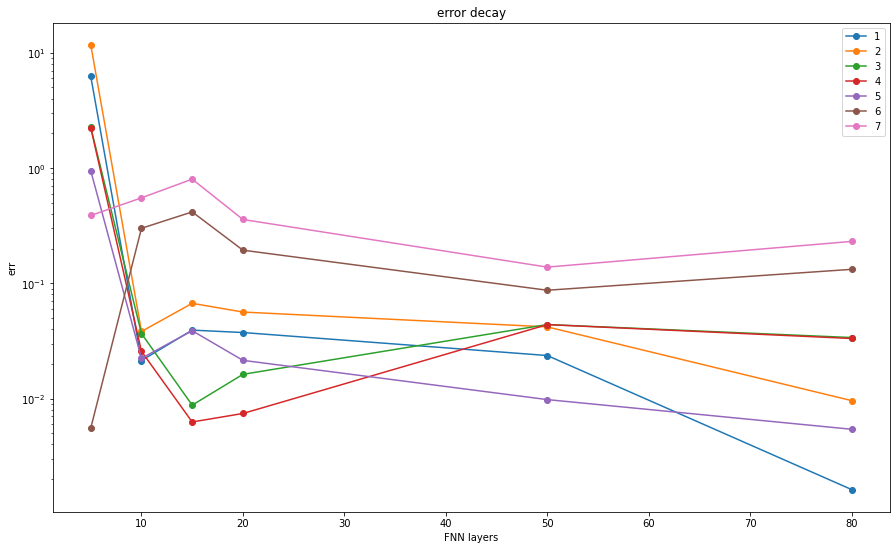

In [ ]:
err = [
    [6.26018000e+00, 1.17270317e+01, 2.25869280e+00, 2.24102527e+00, 9.48152672e-01, 5.53393364e-03, 3.87577295e-01],
    [2.13752985e-02, 3.82152796e-02, 3.66648436e-02, 2.56857872e-02, 2.23445296e-02, 3.00155163e-01, 5.51244497e-01],
    [3.92518044e-02, 6.70270920e-02, 8.76951218e-03, 6.26611710e-03, 3.87958288e-02, 4.16274190e-01, 8.01165342e-01],
    [0.03741235, 0.05632234, 0.01623178, 0.00742519, 0.02146292, 0.1938529, 0.3578341],
    [0.0236311, 0.04188013, 0.04389668, 0.04382348, 0.00979698, 0.08706307, 0.13818598],
    [0.00162429, 0.00960088, 0.03384674, 0.03320718, 0.00541639, 0.1321981, 0.23093987]
    ]
t = [5, 10, 15, 20, 50, 80]
err = np.array(err)
plt.figure(figsize = (15, 9))
for i in range(7):
    y = err[:,i]
    plt.semilogy(t, y, 'o-', label = str(i+1))
plt.legend()
plt.title('error decay')
plt.xlabel('FNN layers')
plt.ylabel('err')
plt.savefig('err_decay.png')

In [ ]:
files.download('err_decay.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>